  # Autoencoder - SNNL Dev

# Setup

In [1]:
# %pwd
# %cd ~/WSL-shared/Cellpainting/pt-snnl/
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [21]:
import os
import sys
import csv
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
from torchinfo import summary
import wandb

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-SNNL-MAIN.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
torch.set_num_threads(3)  ## <--- limit to ~ 2 CPUs
torch.get_num_threads()

['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']


3

In [22]:
from KevinsRoutines.utils.utils_wandb import init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general import list_namespace, print_heading, print_underline

import snnl.utils as utils
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import plot_model_parms, plot_train_history, plot_regression_metrics
from snnl.utils import display_model_summary, display_model_hyperparameters, display_model_gradients, display_model_parameters
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_state_dict
from snnl.utils import define_autoencoder_model, init_resume_training

In [23]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}  \t\t Number of threads: {torch.get_num_threads()}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" WandB version    : {wandb.__version__}  \t\t Pandas version: {pd.__version__}  ")
# logger.info(f" Search path      : {sys.path}")

2024-09-04 23:56:09,087 - __main__ - INFO: -  Excution started : 2024_09_04_23:56:09 
2024-09-04 23:56:09,088 - __main__ - INFO: -  Pytorch version  : 2.2.2  		 Number of threads: 3
2024-09-04 23:56:09,090 - __main__ - INFO: -  Scipy version    : 1.12.0  		 Numpy version : 1.26.4
2024-09-04 23:56:09,090 - __main__ - INFO: -  WandB version    : 0.17.4  		 Pandas version: 2.2.1  


### main(args)

In [24]:
GPU_ID = 0
LATENT_DIM    = 150
HIDDEN_1      = 512
EPOCHS        = 400
COMPOUNDS_PER_BATCH = 200
LEARNING_RATE = 1.00e-04
TEMP          = 1.00
TEMP_LR       = 0.00   ##1.0e-05
ADAM_WEIGHT_DECAY = 0.001
SNNL_FACTOR   = 30.0
# CHECKPT       = f"AE_snnl_dcpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt"
# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_20240709_2235_LAST_ep_700.pt"
# RUN_ID        = "jzt6ecjz"
# print(CHECKPT)

In [25]:
# if __name__ == "__main__":
cli_args = f" --runmode             snnl "\
            f" --configuration      ./hyperparameters/ae_snglopt_150_512_cpb.yaml" \
            f" --epochs             {EPOCHS} " \
            f" --single_loss        "\
            f" --prim_opt           "\
            f" --temp_annealing     "\
            f" --anneal_patience    30"\
            f" --adam_wd            {ADAM_WEIGHT_DECAY}"\
            f" --lr                 {LEARNING_RATE} "\
            f" --temp               {TEMP} "\
            f" --snnl_factor        {SNNL_FACTOR}"\
            f" --temp_lr            {TEMP_LR}"\
            f" --cpb                {COMPOUNDS_PER_BATCH}"\
            f" --seed               4321"\
            f" --gpu_id             {GPU_ID} "  \
            f" --wandb              "\
            f" "

# f" --loss_factor        {LOSS_FACTOR}"\
# f" --run_id             {RUN_ID} "\
# f" --ckpt               {CHECKPT} " \
# f" --temp_opt " \
# f" --ckpt               AE_snnl_dcpb200_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt " \
# f" --ckpt               AE_baseline_{DATE}_snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}_ep_{LOAD_EPOCH}.pt " \
# f" --configuration      hyperparameters/ae_sn_{LATENT_DIM:03d}{HIDDEN_1}{HIDDEN_2}_cpb.yaml" \
# f" --exp_title           snglOpt-050Ltnt_512_sig "
# f" --runmode            snnl" \
cli_args = utils.parse_args(cli_args.split())
cli_args

args = utils.load_configuration(cli_args)
args.ckpt

Namespace(configuration='./hyperparameters/ae_snglopt_150_512_cpb.yaml', ckpt=None, cpb=200, exp_title=None, epochs=400, gpu_id=0, learning_rate=0.0001, exp_id=None, runmode='snnl', random_seed=4321, use_prim_optimizer=True, use_temp_optimizer=False, use_annealing=True, anneal_patience=30, use_single_loss=True, temperature=1.0, adam_weight_decay=0.001, loss_factor=None, snnl_factor=30.0, temperatureLR=0.0, WANDB_ACTIVE=True)

2024-09-04 23:56:14,175 - snnl.utils.utils_ptsnnl - INFO: -  command line param configuration             : [./hyperparameters/ae_snglopt_150_512_cpb.yaml]
2024-09-04 23:56:14,176 - snnl.utils.utils_ptsnnl - INFO: -  command line param ckpt                      : [None]
2024-09-04 23:56:14,177 - snnl.utils.utils_ptsnnl - INFO: -  command line param cpb                       : [200]
2024-09-04 23:56:14,177 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_title                 : [None]
2024-09-04 23:56:14,178 - snnl.utils.utils_ptsnnl - INFO: -  command line param epochs                    : [400]
2024-09-04 23:56:14,179 - snnl.utils.utils_ptsnnl - INFO: -  command line param gpu_id                    : [0]
2024-09-04 23:56:14,179 - snnl.utils.utils_ptsnnl - INFO: -  command line param learning_rate             : [0.0001]
2024-09-04 23:56:14,180 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_id                    : [None]
2024-09-04 23:56:14,180 - snnl.utils.utils

In [26]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0
WANDB_ACTIVE.............  True
adam_weight_decay........  0.001
anneal_patience..........  30
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  200
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_star

In [27]:
### Set random seed and gpu device
set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f"Checkpoint {args.ckpt} found")
        logger.info(f"Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f"*** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

if args.gpu_id is not None:
    _ = get_device(verbose=True)
    # print(f"Current device is : {current_device}")
    args.current_device = set_device(args.gpu_id)

2024-09-04 23:56:16,524 - snnl.utils.utils_ptsnnl - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-09-04 23:56:16,525 - snnl.utils.utils_ptsnnl - INFO: -  Switched to: Quadro GV100 - 0


 device: 0   Quadro GV100                   :  free: 32,677,363,712 B   (30.43 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 1   Quadro GV100                   :  free: 32,870,301,696 B   (30.61 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 2   NVIDIA TITAN Xp                :  free: 12,099,125,248 B   (11.27 GB)    total: 12,774,539,264 B   (11.90 GB)


  ### WandB Setup

In [28]:
wandb_run = utils.setup_wandb(args)
logger.info(f" WANDB_ACTIVE     : {args.WANDB_ACTIVE}")

2024-09-04 23:56:18,069 - snnl.utils.utils_notebook - INFO: - ***** Initialize NEW  W&B Run *****


None, AE_20240904_2356, CellPainting_Profiles


2024-09-04 23:56:23,669 - snnl.utils.utils_notebook - INFO: -  Experiment Name  : AE_20240904_2356
2024-09-04 23:56:23,671 - snnl.utils.utils_notebook - INFO: -  Experiment Date  : 20240904_2356
2024-09-04 23:56:23,673 - snnl.utils.utils_notebook - INFO: - ***** Initialize NEW  W&B Run *****
2024-09-04 23:56:23,674 - snnl.utils.utils_notebook - INFO: - WANDB_ACTIVE     : True
2024-09-04 23:56:23,675 - snnl.utils.utils_notebook - INFO: - Project Name     : CellPainting_Profiles
2024-09-04 23:56:23,676 - snnl.utils.utils_notebook - INFO: - Experiment Id    : ynhcz556
2024-09-04 23:56:23,677 - snnl.utils.utils_notebook - INFO: - Experiment Name  : AE_20240904_2356
2024-09-04 23:56:23,678 - snnl.utils.utils_notebook - INFO: - Experiment Date  : 20240904_2356
2024-09-04 23:56:23,680 - snnl.utils.utils_notebook - INFO: - Experiment Title : dcpb200_150Ltnt_512
2024-09-04 23:56:23,681 - snnl.utils.utils_notebook - INFO: - Experiment Notes : AE snnl - DualOpt, 150 dim latent, 512 Midlayer, 200 

In [29]:
# if args.WANDB_ACTIVE:
#     wandb_run.finish()
#     WANDB_ACTIVE = False

  ### Define dataset and dataloaders

In [30]:
# args.cellpainting_args

In [31]:
#### Load CellPainting Dataset
data_loaders = utils.build_dataloaders(args, data = ['train', 'val'])

2024-09-04 23:56:54,802 - root - INFO: -  load cellpainting
2024-09-04 23:56:54,804 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-09-04 23:56:54,805 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
2024-09-04 23:56:54,806 - snnl.utils.dataloader - INFO: -  type    :  train
2024-09-04 23:56:54,807 - snnl.utils.dataloader - INFO: -  start   :  0
2024-09-04 23:56:54,808 - snnl.utils.dataloader - INFO: -  end     :  240000
2024-09-04 23:56:54,809 - snnl.utils.dataloader - INFO: -  numrows :  240000
2024-09-04 23:56:54,810 - snnl.utils.dataloader - INFO: -  names   :  None     usecols :  None
2024-09-04 23:56:54,810 - snnl.utils.dataloader - INFO: -  batch_size  :  1
2024-09-04 23:56:54,811 - snnl.utils.dataloader - INFO: -  sample_size :  3
2024-09-04 23:56:54,812 - snnl.utils.dataloader - INFO: -  compounds_per_batch :  200
2024-09-04 23:56:54,

 load cellpainting
 Dataset size: 240000   rows per batch: 600
 Dataset size: 24000   rows per batch: 600


# Define autoencoder model

### Override arguments

In [32]:
# args.runmode
# args.temperature   = 1.0
# args.loss_factor   = 1.0       ## 1.0e+00
# args.learning_rate = 1.0e-03    ## 0.001
# args.temperatureLR = 0.0e-04    ## 1e-4
print(f"   runmode                  {args.runmode}")
print(f"   embedding_layer          {args.embedding_layer}")
print(f"   Latent dim               {args.code_units}")
print(f"   loss_factor              {args.loss_factor}")
print(f"   snnl_factor              {args.snnl_factor}")
print(f"   temperature              {args.temperature}")
print(f"   learning_rate            {args.learning_rate}")
print(f"   temperatureLR:           {args.temperatureLR}")
print(f"   use_annealing:           {args.use_annealing}")
print(f"   anneal_patience:         {args.anneal_patience}")
print(f"   use Primary Optimizer:   {args.use_prim_optimizer}")
print(f"   use Primary Scheduler:   {args.use_prim_scheduler}")


   runmode                  snnl
   embedding_layer          4
   Latent dim               150
   loss_factor              1.0
   snnl_factor              30.0
   temperature              1.0
   learning_rate            0.0001
   temperatureLR:           0.0
   use_annealing:           True
   anneal_patience:         30
   use Primary Optimizer:   True
   use Primary Scheduler:   True


In [33]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0
WANDB_ACTIVE.............  True
adam_weight_decay........  0.001
anneal_patience..........  30
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  200
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_star

In [34]:
### Define Model
args.runmode
model = define_autoencoder_model(args, verbose = True)

'snnl'

2024-09-04 23:56:55,863 - snnl.utils.utils_notebook - INFO: - Defining model in SNNL mode 
2024-09-04 23:56:55,868 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-09-04 23:56:55,886 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-04 23:56:55,887 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-09-04 23:56:55,894 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-04 23:56:55,895 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    150    weights: [150, 512]   
2024-09-04 23:56:55,897 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input:    

 EMBEDDING LAYER: 4
 Device cuda:0 will be used

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              latent_code
    Model_init()_    -- Unsupervised :     True
    Model_init()_    -- Support for unsupervised training  in 'latent_code' mode is True
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         True
    Model_init()_    -- temperature :      Parameter containing:
tensor([1.])
    Model_init()_    -- temperature LR:    0.0

------------------------------------------------------------
 Building Autoencoder from NOTEBOOK
------------------------------------------------------------
setup_prim_optimizer()
    AE init() -- mode               : latent_code
    AE init() -- unsupervised       : True
    AE init() -- layer_types        : ['linear', 'relu', 'linear', 'relu', 'linear', 'linear', 'relu'

## Resume from model checkpoint (if args.ckpt is not None)

In [35]:
args.load_checkpoint = utils.load_checkpoint_v5
args.save_checkpoint = utils.save_checkpoint_v5
print(f" Checkpoint File :  {args.ckpt}")

model = init_resume_training(model, args)

if args.WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
    wandb.config.update(args)

2024-09-04 23:56:57,600 - root - INFO: -  INITIALIZE TRAINING - Run 400 epochs: epoch 1 to 400 


 Checkpoint File :  None


In [36]:
# display_model_state_dict(model, 'test')
# display_model_parameters(model, 'title')
# display_model_gradients(model, 'test')
# display_model_hyperparameters(model)

# for k,v in model.__dict__.items():
#     if k == 'training_history':
#         print(f" {k:30}  type: {str(type(v)):25s}   values: {v.keys()} ")
#     else:
#         print(f" {k:30}  type: {str(type(v)):25s}   values: {v} ")

# display_model_hyperparameters(model)

# model.optimizers['prim'].state_dict()
# model.schedulers['prim'].state_dict()

# print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].param_groups[0]}")
# for k,v in model.optimizers.items():
#     print(k, v)

# for k,v in enumerate(model.optimizers['prim'].param_groups[0]['params']):
#     print(f" {k}, {v.shape}")

# model.display_values('test')
# model.display_gradients('test')
# model.optimizers['prim'].state_dict()

# Autoencoder Fit 

In [37]:
# model.starting_epoch = 0
model.ending_epoch = 400
# model.starting_epoch, model.ending_epoch = 700, 705
model.starting_epoch, model.ending_epoch

print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

(0, 400)

 2024-09-04 23:57:00  epoch    1 of  400


In [38]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders, DEBUG_COUNT = 2)
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")


 2024-09-04 23:57:01  Start: epoch    1 of  400
                                                                                                                                                                           

2024-09-04 23:59:41,368 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 1


  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
23:59:41  1 /400  | 162.6275     0.9563   161.6712 |   1.000000   0.0000e+00 | -17.0376     1           | 158.0361     0.6735   157.3625 |  -2.6621     1             |  1.000e-04   0.000e+00 |
00:02:22  2 /400  | 156.0792     0.6235   155.4557 |   1.000000   0.0000e+00 |  -1.3357     2           | 155.3034     0.5652   154.7382 |  -0.4277     2             |  1.000e-04   0.000e+00 |


2024-09-05 00:02:22,602 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 2


00:05:06  3 /400  | 154.3656     0.5457   153.8199 |   1.000000   0.0000e+00 |  -0.1403     3           | 154.4167     0.5111   153.9056 |   0.1438     3             |  1.000e-04   0.000e+00 |


2024-09-05 00:05:06,962 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 3


00:07:49  4 /400  | 153.5239     0.5049   153.0189 |   1.000000   0.0000e+00 |   0.2286     4           | 153.8985     0.4845   153.4140 |   0.3281     4             |  1.000e-04   0.000e+00 |


2024-09-05 00:07:49,469 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 4


00:10:24  5 /400  | 152.9278     0.4855   152.4423 |   1.000000   0.0000e+00 |   0.3692     5           | 153.5222     0.4722   153.0500 |   0.4014     5             |  1.000e-04   0.000e+00 |


2024-09-05 00:10:25,282 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 5


00:13:01  6 /400  | 152.4380     0.4751   151.9629 |   1.000000   0.0000e+00 |   0.4287     6           | 153.2432     0.4650   152.7782 |   0.4410     6             |  1.000e-04   0.000e+00 |


2024-09-05 00:13:01,610 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 6


00:15:35  7 /400  | 152.0075     0.4690   151.5385 |   1.000000   0.0000e+00 |   0.4568     7           | 153.0274     0.4614   152.5660 |   0.4592     7             |  1.000e-04   0.000e+00 |


2024-09-05 00:15:35,815 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 7


00:18:09  8 /400  | 151.6143     0.4658   151.1485 |   1.000000   0.0000e+00 |   0.4702     8           | 152.8508     0.4592   152.3916 |   0.4680     8             |  1.000e-04   0.000e+00 |


2024-09-05 00:18:09,712 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 8


00:20:42  9 /400  | 151.2458     0.4644   150.7815 |   1.000000   0.0000e+00 |   0.4751     9           | 152.7126     0.4579   152.2546 |   0.4721     9             |  1.000e-04   0.000e+00 |


2024-09-05 00:20:42,865 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 9


00:23:17 10 /400  | 150.8982     0.4634   150.4348 |   1.000000   0.0000e+00 |   0.4772    10           | 152.6076     0.4575   152.1501 |   0.4743    10             |  1.000e-04   0.000e+00 |


2024-09-05 00:23:17,763 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 10


00:25:51 11 /400  | 150.5667     0.4635   150.1032 |   1.000000   0.0000e+00 |   0.4772    11           | 152.5413     0.4581   152.0833 |   0.4742    10             |  1.000e-04   0.000e+00 |
00:28:25 12 /400  | 150.2488     0.4638   149.7849 |   1.000000   0.0000e+00 |   0.4765    11           | 152.5032     0.4581   152.0451 |   0.4752    12             |  1.000e-04   0.000e+00 |


2024-09-05 00:28:26,288 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_BEST.pt - epoch: 12


00:30:59 13 /400  | 149.9378     0.4647   149.4731 |   1.000000   0.0000e+00 |   0.4758    11           | 152.4918     0.4587   152.0330 |   0.4738    12             |  1.000e-04   0.000e+00 |
00:33:33 14 /400  | 149.6350     0.4664   149.1686 |   1.000000   0.0000e+00 |   0.4737    11           | 152.4993     0.4606   152.0387 |   0.4722    12             |  1.000e-04   0.000e+00 |
00:36:09 15 /400  | 149.3415     0.4689   148.8726 |   1.000000   0.0000e+00 |   0.4709    11           | 152.5101     0.4639   152.0463 |   0.4685    12             |  1.000e-04   0.000e+00 |
00:38:43 16 /400  | 149.0589     0.4725   148.5863 |   1.000000   0.0000e+00 |   0.4669    11           | 152.5779     0.4683   152.1097 |   0.4642    12             |  1.000e-04   0.000e+00 |
00:41:17 17 /400  | 148.7870     0.4766   148.3103 |   1.000000   0.0000e+00 |   0.4621    11           | 152.6630     0.4715   152.1915 |   0.4606    12             |  1.000e-04   0.000e+00 |
00:43:50 18 /400  | 148.5437     0.

2024-09-05 02:32:43,031 - snnl.models.base - INFO: -  Main learning rate reduced to [5e-05]


02:32:43 61 /400  | 146.3689     0.5630   145.8059 |   1.000000   0.0000e+00 |   0.3724    11           | 153.1933     0.5600   152.6333 |   0.3783    12             |  1.000e-04   0.000e+00 |
02:34:59 62 /400  | 146.4481     0.5583   145.8898 |   1.000000   0.0000e+00 |   0.3852    11           | 153.0654     0.5523   152.5131 |   0.3898    12             |  5.000e-05   0.000e+00 |              
02:37:15 63 /400  | 146.2085     0.5581   145.6504 |   1.000000   0.0000e+00 |   0.3850    11           | 153.1119     0.5533   152.5585 |   0.3886    12             |  5.000e-05   0.000e+00 |              
02:39:31 64 /400  | 146.0791     0.5590   145.5201 |   1.000000   0.0000e+00 |   0.3838    11           | 153.1600     0.5544   152.6055 |   0.3876    12             |  5.000e-05   0.000e+00 |              
02:41:47 65 /400  | 145.9979     0.5600   145.4379 |   1.000000   0.0000e+00 |   0.3828    11           | 153.2147     0.5555   152.6592 |   0.3865    12             |  5.000e-05   0.000

2024-09-05 04:01:29,499 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_100.pt - epoch: 100


04:01:29 100/400  | 135.6101     0.6136   134.9965 |   0.683020   0.0000e+00 |   0.3282    11           | 148.2590     0.6112   147.6478 |   0.3326    12             |  5.000e-05   0.000e+00 |
04:03:46 101/400  | 135.5804     0.6148   134.9656 |   0.683020   0.0000e+00 |   0.3275    11           | 148.2915     0.6122   147.6793 |   0.3316    12             |  5.000e-05   0.000e+00 |              
04:06:02 102/400  | 135.5489     0.6160   134.9329 |   0.683020   0.0000e+00 |   0.3261    11           | 148.2782     0.6134   147.6647 |   0.3300    12             |  5.000e-05   0.000e+00 |              
04:08:19 103/400  | 135.5226     0.6172   134.9054 |   0.683020   0.0000e+00 |   0.3247    11           | 148.3331     0.6141   147.7190 |   0.3295    12             |  5.000e-05   0.000e+00 |              
04:10:37 104/400  | 135.4941     0.6184   134.8757 |   0.683020   0.0000e+00 |   0.3235    11           | 148.3354     0.6153   147.7201 |   0.3283    12             |  5.000e-05   0.000

2024-09-05 04:51:43,562 - snnl.models.base - INFO: -  Main learning rate reduced to [2.5e-05]


04:51:43 122/400  | 128.0252     0.6395   127.3857 |   0.546491   0.0000e+00 |   0.3020    11           | 145.8408     0.6307   145.2102 |   0.3095    12             |  5.000e-05   0.000e+00 |
04:54:00 123/400  | 128.3606     0.6372   127.7234 |   0.546491   0.0000e+00 |   0.3086    11           | 145.2257     0.6264   144.5993 |   0.3152    12             |  2.500e-05   0.000e+00 |              
04:56:16 124/400  | 128.1397     0.6373   127.5023 |   0.546491   0.0000e+00 |   0.3080    11           | 145.2586     0.6270   144.6316 |   0.3144    12             |  2.500e-05   0.000e+00 |              
04:58:32 125/400  | 127.9630     0.6379   127.3251 |   0.546491   0.0000e+00 |   0.3073    11           | 145.3615     0.6274   144.7341 |   0.3139    12             |  2.500e-05   0.000e+00 |              
05:00:49 126/400  | 127.8373     0.6386   127.1987 |   0.546491   0.0000e+00 |   0.3064    11           | 145.4859     0.6282   144.8577 |   0.3131    12             |  2.500e-05   0.000

2024-09-05 07:11:12,589 - snnl.models.base - INFO: -  Main learning rate reduced to [1.25e-05]


07:11:12 183/400  | 116.8169     0.6720   116.1449 |   0.412635   0.0000e+00 |   0.2714    11           | 143.2342     0.6608   142.5734 |   0.2800    12             |  2.500e-05   0.000e+00 |
07:13:29 184/400  | 116.9219     0.6713   116.2507 |   0.412635   0.0000e+00 |   0.2739    11           | 142.5419     0.6596   141.8823 |   0.2810    12             |  1.250e-05   0.000e+00 |              
07:15:47 185/400  | 116.6954     0.6715   116.0238 |   0.412635   0.0000e+00 |   0.2734    11           | 142.7631     0.6604   142.1027 |   0.2800    12             |  1.250e-05   0.000e+00 |              
07:18:05 186/400  | 116.5674     0.6721   115.8953 |   0.412635   0.0000e+00 |   0.2727    11           | 142.8951     0.6608   142.2342 |   0.2795    12             |  1.250e-05   0.000e+00 |              
07:20:23 187/400  | 116.4844     0.6726   115.8118 |   0.412635   0.0000e+00 |   0.2720    11           | 143.0630     0.6616   142.4014 |   0.2788    12             |  1.250e-05   0.000

2024-09-05 07:50:15,456 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_200.pt - epoch: 200


07:50:15 200/400  | 112.2780     0.6782   111.5998 |   0.373265   0.0000e+00 |   0.2660    11           | 142.2034     0.6664   141.5370 |   0.2735    12             |  1.250e-05   0.000e+00 |
07:52:31 201/400  | 112.2404     0.6786   111.5619 |   0.373265   0.0000e+00 |   0.2656    11           | 142.2778     0.6672   141.6106 |   0.2726    12             |  1.250e-05   0.000e+00 |              
07:54:48 202/400  | 112.2094     0.6789   111.5306 |   0.373265   0.0000e+00 |   0.2653    11           | 142.3232     0.6673   141.6559 |   0.2726    12             |  1.250e-05   0.000e+00 |              
07:57:05 203/400  | 112.1951     0.6794   111.5157 |   0.373265   0.0000e+00 |   0.2648    11           | 142.3619     0.6679   141.6940 |   0.2719    12             |  1.250e-05   0.000e+00 |              
07:59:22 204/400  | 112.1863     0.6797   111.5066 |   0.373265   0.0000e+00 |   0.2644    11           | 142.3718     0.6683   141.7035 |   0.2715    12             |  1.250e-05   0.000

2024-09-05 09:31:38,208 - snnl.models.base - INFO: -  Main learning rate reduced to [6.25e-06]


09:31:38 244/400  | 108.1692     0.6926   107.4766 |   0.342923   0.0000e+00 |   0.2512    11           | 142.2214     0.6820   141.5394 |   0.2575    12             |  1.250e-05   0.000e+00 |
09:33:56 245/400  | 108.2617     0.6925   107.5692 |   0.342923   0.0000e+00 |   0.2524    11           | 142.1828     0.6817   141.5011 |   0.2575    12             |  6.250e-06   0.000e+00 |              
09:36:13 246/400  | 108.1150     0.6928   107.4222 |   0.342923   0.0000e+00 |   0.2520    11           | 142.4148     0.6820   141.7328 |   0.2570    12             |  6.250e-06   0.000e+00 |              
09:38:32 247/400  | 108.0475     0.6930   107.3545 |   0.342923   0.0000e+00 |   0.2516    11           | 142.4916     0.6822   141.8094 |   0.2569    12             |  6.250e-06   0.000e+00 |              
09:41:01 248/400  | 108.0074     0.6932   107.3142 |   0.342923   0.0000e+00 |   0.2513    11           | 142.5624     0.6825   141.8799 |   0.2566    12             |  6.250e-06   0.000

2024-09-05 11:55:32,857 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_300.pt - epoch: 300


11:55:32 300/400  | 101.6124     0.7022   100.9101 |   0.298653   0.0000e+00 |   0.2420    11           | 142.2311     0.6917   141.5394 |   0.2470    12             |  6.250e-06   0.000e+00 |
11:58:05 301/400  | 101.6003     0.7023   100.8980 |   0.298653   0.0000e+00 |   0.2418    11           | 142.2266     0.6917   141.5349 |   0.2470    12             |  6.250e-06   0.000e+00 |              
12:00:45 302/400  | 101.5924     0.7025   100.8899 |   0.298653   0.0000e+00 |   0.2417    11           | 142.2441     0.6918   141.5523 |   0.2468    12             |  6.250e-06   0.000e+00 |              
12:03:24 303/400  | 101.5817     0.7026   100.8790 |   0.298653   0.0000e+00 |   0.2416    11           | 142.2411     0.6919   141.5492 |   0.2467    12             |  6.250e-06   0.000e+00 |              
12:06:03 304/400  | 101.5584     0.7028   100.8556 |   0.298653   0.0000e+00 |   0.2414    11           | 142.2563     0.6920   141.5643 |   0.2466    12             |  6.250e-06   0.000

2024-09-05 12:08:44,212 - snnl.models.base - INFO: -  Main learning rate reduced to [3.125e-06]


12:08:44 305/400  | 101.5424     0.7029   100.8396 |   0.298653   0.0000e+00 |   0.2413    11           | 142.2883     0.6921   141.5962 |   0.2465    12             |  6.250e-06   0.000e+00 |
12:11:25 306/400  | 101.5828     0.7029   100.8799 |   0.298653   0.0000e+00 |   0.2420    11           | 142.2945     0.6923   141.6022 |   0.2462    12             |  3.125e-06   0.000e+00 |              
12:14:05 307/400  | 101.5103     0.7030   100.8073 |   0.298653   0.0000e+00 |   0.2419    11           | 142.3752     0.6924   141.6828 |   0.2460    12             |  3.125e-06   0.000e+00 |              
12:16:43 308/400  | 101.4828     0.7031   100.7797 |   0.298653   0.0000e+00 |   0.2417    11           | 142.4021     0.6925   141.7096 |   0.2458    12             |  3.125e-06   0.000e+00 |              
12:19:21 309/400  | 101.4539     0.7032   100.7507 |   0.298653   0.0000e+00 |   0.2415    11           | 142.4305     0.6926   141.7379 |   0.2457    12             |  3.125e-06   0.000

2024-09-05 14:49:40,102 - snnl.models.base - INFO: -  Main learning rate reduced to [1.5625e-06]


14:49:40 366/400  |  96.2158     0.7077    95.5082 |   0.267445   0.0000e+00 |   0.2370    11           | 142.5619     0.6969   141.8650 |   0.2412    12             |  3.125e-06   0.000e+00 |
14:52:15 367/400  |  96.2090     0.7077    95.5013 |   0.267445   0.0000e+00 |   0.2374    11           | 142.5693     0.6967   141.8726 |   0.2412    12             |  1.563e-06   0.000e+00 |              
14:54:49 368/400  |  96.1612     0.7077    95.4535 |   0.267445   0.0000e+00 |   0.2373    11           | 142.6034     0.6968   141.9066 |   0.2411    12             |  1.563e-06   0.000e+00 |              
14:57:24 369/400  |  96.1458     0.7078    95.4380 |   0.267445   0.0000e+00 |   0.2372    11           | 142.6235     0.6968   141.9267 |   0.2410    12             |  1.563e-06   0.000e+00 |              
15:00:00 370/400  |  96.1347     0.7078    95.4269 |   0.267445   0.0000e+00 |   0.2371    11           | 142.6368     0.6969   141.9399 |   0.2409    12             |  1.563e-06   0.000

2024-09-05 16:16:29,747 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_ep_400.pt - epoch: 400


16:16:29 400/400  |  93.9180     0.7092    93.2088 |   0.254947   0.0000e+00 |   0.2358    11           | 142.7533     0.6982   142.0552 |   0.2396    12             |  1.563e-06   0.000e+00 |
Last Epoch 400


2024-09-05 16:16:29,837 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_20240904_2356_LAST_ep_400.pt - epoch: 400


 2024-09-05 16:16:29  End: epoch  400 of  400


In [ ]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders )
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")


 2024-09-05 21:19:38  Start: epoch  401 of  600
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |              
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
21:22:37 401/600  |  93.9091     0.7092    93.1999 |   0.254947   0.0000e+00 |   0.2357    11           | 142.7719     0.6982   142.0737 |   0.2395    12             |  1.563e-06   0.000e+00 |
21:25:38 402/600  |  93.9029     0.7092    93.1937 |   0.254947   0.0000e+00 |   0.2357    11           | 142.7662     0.6983   142.0679 |   0.2395    12             |  1.563e-06   0.000e+00 |              
21:28:38 403/600  |  93.8958     0.7092    93.1866 |   0.254947   0.0000e+00 |   0.2357    11           | 142.7879     0.6982   142.0897 |   0.2395    1

In [ ]:
# model.use_temp_optimizer
# take_checkpoint(model, args, epoch=306, update_best = True)
# model.use_temp_optimizer
# model.temp_params
# model.anneal_patience = 30
# model.optimizers['prim'].param_groups[0]
# torch.get_num_threads()
torch.set_num_threads(4)
torch.get_num_threads()

In [43]:
model.epoch, model.starting_epoch, model.ending_epoch

(599, 400, 600)

In [44]:
for epoch in range(model.ending_epoch):
    display_epoch_metrics(model, epoch)

  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
23:59:41  1 /600  | 162.6275     0.9563   161.6712 |   1.000000   0.0000e+00 | -17.0376    11           | 158.0361     0.6735   157.3625 |  -2.6621    12             |  1.000e-04   0.000e+00 |
00:02:22  2 /600  | 156.0792     0.6235   155.4557 |   1.000000   0.0000e+00 |  -1.3357    11           | 155.3034     0.5652   154.7382 |  -0.4277    12             |  1.000e-04   0.000e+00 |
00:05:06  3 /600  | 154.3656     0.5457   153.8199 |   1.000000   0.0000e+00 |  -0.1403    11           | 154.4167     0.5111   153.9056 |   0.1438    12             |  1.000e-04   0.000e+00 |
00:07:49  4 /600  | 153.5239     0.

In [41]:
# model.starting_epoch = 100
# model.ending_epoch = 200
model.starting_epoch = model.ending_epoch
# model.starting_epoch = 512
model.ending_epoch += 200

print(f" {datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

 20240905_211934  epoch  401 of  600


### Close WandB Logging

In [46]:
if args.WANDB_ACTIVE:
    wandb_run.finish()
    args.WANDB_ACTIVE = False

temp_grad_hist,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temp_hist,█████▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temp_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_R2_score,██▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_best_loss,███▇▇▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
trn_best_loss_ep,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trn_best_metric,▁███████████████████████████████████████
trn_best_metric_ep,▁███████████████████████████████████████
trn_lr,████▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_prim_loss,▁▁▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇███████████████████████
trn_snn_loss,███▇▇▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁


## Misc stuff

In [ ]:
# for p in model.layers:
#     if hasattr(p, 'weight'):
#         p.weight.shape, p.bias.shape
# model.training_history['trn'].keys()
# # model.training_history['trn']['L04_W_grad']
# model.optimizers['prim']
# model.state_dict()['layers.0.weight']
# model.optimizers['prim'].zero_grad()
# layers.0.weight
# display_model_gradients(model, 'test')
# model.state_dict()['layers.0.weight'].requires_grad
# model.temperature.data
# model.snnl_criterion.temperature

In [ ]:
display_epoch_metrics(model, model.epoch, model.ending_epoch, header = True)

In [ ]:
# model.starting_epoch, model.ending_epoch = 0, 2
# epoch = 1
# model.temperature = torch.abs(model.temperature)
# model.temperature = torch.nn.Parameter(torch.clip(model.temperature, 0.001, None))
# model.snnl_criterion.temperature= torch.nn.Parameter(torch.clip(model.snnl_criterion.temperature, 0.001, None))

In [ ]:
# model.state_dict().keys()
# # for k in ['temperature', 'snnl_criterion.temperature'
# for k in ['temperature', 'snnl_criterion.temperature','layers.0.weight', 'layers.0.bias','layers.2.weight','layers.4.weight','layers.4.bias','layers.5.weight','layers.5.bias','layers.7.weight','layers.9.weight','layers.9.bias',]:
#     if model.state_dict()[k].ndim > 1:
#         print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:3,:3].reshape((-1)).data}")
#     else:
#         print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:9].data}")


# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

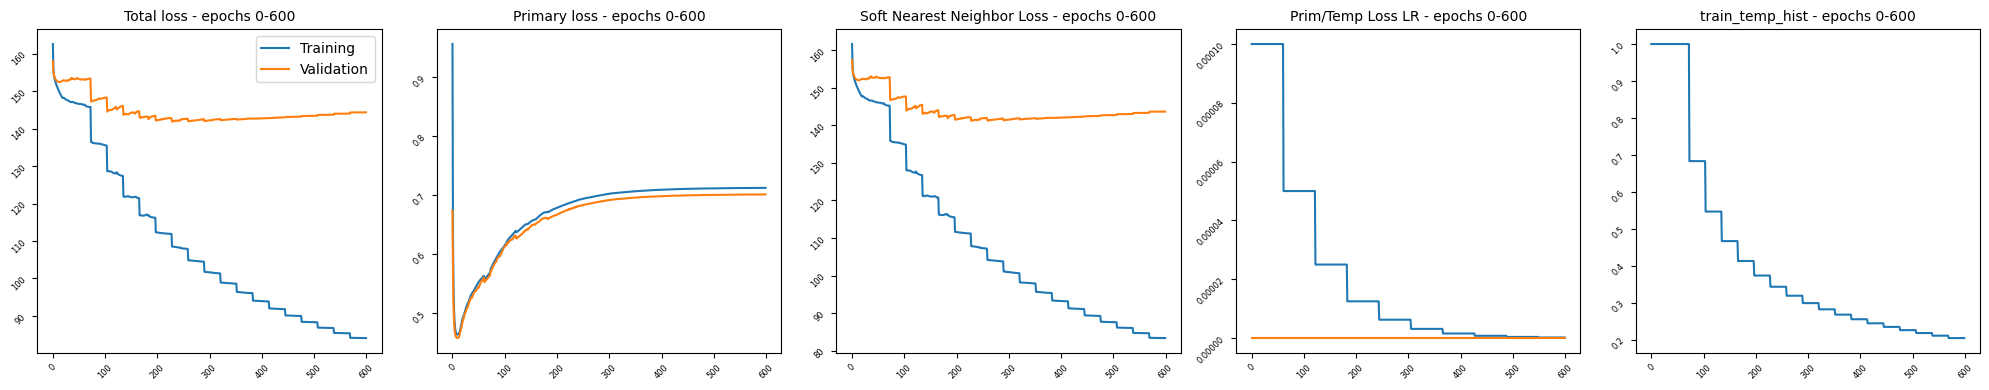

In [45]:
plot_train_history(model, start= 0, n_bins = 25)

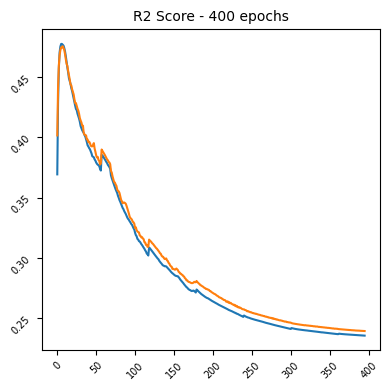

In [40]:
plot_regression_metrics(model,start = 4, n_bins = 25)

In [ ]:
# plot_train_metrics(model, n_bins = 25)
# plot_regression_metrics(model,start = 4, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 100, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_model_parms(model, epochs= model.epoch, n_bins = 15)

# Load model

In [ ]:
ex_name = 'AE'
ex_epoch = 50
ex_runmode = 'snnl'
ex_date = '20240718'
ex_time = '1956'
ex_title = args.exp_title
compounds_per_batch = args.cpb
print(args.exp_title)
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
# ex_epoch = 200

In [ ]:
# filename = f"{model.name}_{args.runmode}_{exp_date}_{exp_title}_ep_{exp_epoch:03d}"
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{ex_name}_{ex_runmode}_{ex_title}_{ex_date}_{ex_time}_{ex_epoch:03d}.pt"
print(filename)
file_pattern = f"{ex_name}_{ex_runmode}_{ex_title}_{ex_date}_{ex_time}_BEST*.pt"
# file_pattern = f"{ex_name}_{ex_runmode}_{ex_title}_{ex_date}_{ex_time}_LAST*.pt"
print(file_pattern)

In [ ]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
# epochlist =sorted([int(x[-6:-3]) for x in filelist])
# epochlist

In [ ]:
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
ex_epoch = 200

filename = f"{model.name}_{args.runmode}_{exp_date}_{exp_title}_ep_{exp_epoch:03d}"
filename = filelist[0]
if filename[-3:] != '.pt':
    filename += '.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

In [ ]:
# mdl , last_epoch = load_checkpoint_v2(model, filename)
mdl, last_epoch, mdl_ckpt = utils.load_checkpoint_v5(model, filename)
print(f" last epoch : {last_epoch}")

In [ ]:
print(args.current_device)
print(mdl.device)
# model.device = current_device
print(mdl.device)

In [ ]:
print(current_device)
model.train()
model = model.cuda(device=current_device)

In [ ]:
starting_epoch, epochs,

In [ ]:
print(f" last epoch  {last_epoch}")

In [ ]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

In [ ]:
print()
print(f" model device              : {model.device}")
print(f" model temperature         : {model.temperature}")
print(f" model use prim_optimizer  : {model.use_prim_optimizer}")
print(f" model use prim_scheduler  : {model.use_prim_scheduler}")
print() 
print(f" loss_factor               : {model.loss_factor}")
print(f" monitor_grads_layer       : {model.monitor_grads_layer}")
print(f" Learning rate             : {model.optimizers['prim'].param_groups[0]['lr']}") 
print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].param_groups[0]}") 
print() 
print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].state_dict()}") 

print(f" snnl_factor               : {model.snnl_factor}")
# if model.use_snnl:
#     print(f" temperature          : {model.temperature.item()}")
# if model.temp_optimizer is not None:
#     print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
# print()

# for th_key in ['trn', 'val']:
#     for k,v in model.training_history[th_key].items():
#         if isinstance(v[-1],str):
#             print(f" {k:20s} : {v[-1]:s}  ")
#         else:
#             print(f" {k:20s} : {v[-1]:6f} ")
#     print()


In [ ]:
model.optimizers['prim']['params']
# model.use_prim_scheduler

In [ ]:
model.optimizers 
print()

In [ ]:
model.scheduler.__dict__

In [ ]:
model.temp_optimizer.__dict__
print()

In [ ]:
model.temp_scheduler.__dict__

# Old fit routine

In [ ]:
# print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
# header = True

# for epoch in range(model.starting_epoch, model.ending_epoch):
#     train_loss = model.epoch_train(train_loader, epoch, DEBUG_COUNT = 0)
#     val_loss = model.epoch_validate(val_loader, epoch)

#     display_epoch_metrics(model, epoch, model.ending_epoch, header)
#     header = False
#     model.scheduling_step(val_loss)

#     if WANDB_ACTIVE:
#         epoch_metrics = {x:y     for x,y in model.training_history['gen'].items()} | \
#                         {x:y[-1] for x,y in model.training_history['val'].items()} | \
#                         {x:y[-1] for x,y in model.training_history['trn'].items()} 
#         wandb_log_metrics( data = epoch_metrics, step = epoch)

#     if model.new_val_best :
#         if WANDB_ACTIVE:
#             wandb.unwatch(model)
#             args.save_checkpoint(epoch+1, model, args, update_best=True)  
#             wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
#         else:
#             args.save_checkpoint(epoch+1, model, args, update_best=True)  

#     if (epoch + 1) % args.save_every == 0:
#         if WANDB_ACTIVE:
#             wandb.unwatch(model)
#             args.save_checkpoint(epoch+1, model, args)    
#             wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
#         else:
#             args.save_checkpoint(epoch+1, model, args)    

# print(f"Last Epoch {epoch+1}")
# if WANDB_ACTIVE:
#     wandb.unwatch(model)
#     args.save_checkpoint(epoch+1, model, args, update_latest=True)          
#     wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
# else:
#     args.save_checkpoint(epoch+1, model, args, update_latest=True)      
